In [18]:
import numpy as np
import pandas as pd
%matplotlib inline 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import torch
import random

In [19]:
class CustomDataset:
    def __init__(self, csv_file, batch_size=16, verbose=False):
        self.test_loader = None
        self.train_loader = None
        self.df = pd.read_csv(csv_file)
        self.batch_size = batch_size
        self.verbose = verbose
        self.preprocess_data()

    def preprocess_data(self):
        X, y = self.df.drop('label', axis=1), self.df['label']
        X = np.array(X)
        X = X.astype('float32') / 255.0
        X = X.reshape(-1, 28, 28, 1)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        train_tensor = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values))
        test_tensor = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values))

        self.train_loader = DataLoader(train_tensor, batch_size=self.batch_size, num_workers=2, shuffle=True)
        self.test_loader = DataLoader(test_tensor, batch_size=self.batch_size, num_workers=2, shuffle=False)

    def get_dataloaders(self):
        return self.train_loader, self.test_loader

custom_dataset = CustomDataset(csv_file='train.csv', batch_size=4, verbose=True)
train_loader, test_loader = custom_dataset.get_dataloaders()

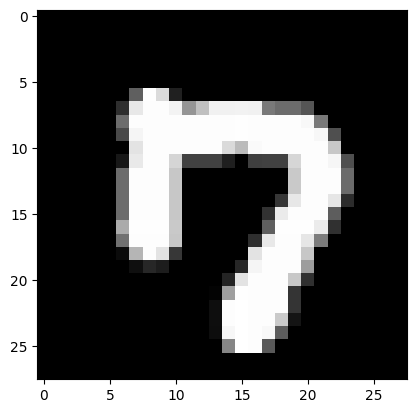

In [20]:
import matplotlib.pyplot as plt

image, label = next(iter(train_loader))
image = image[0].cpu().numpy()

plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [21]:
numpy_img = train_loader.dataset[10][0].numpy()
print(numpy_img.shape)

(28, 28, 1)


In [22]:
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
net = FullyConnectedNet()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 

for epoch in tqdm(range(3)):
    running_loss = 0.0 
    for i, batch in enumerate(tqdm(train_loader)): 
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net(X_batch) 
        loss = loss_fn(y_pred, y_batch) 
        loss.backward()
        optimizer.step() 
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Обучение закончено')

 25%|██▍       | 2069/8400 [00:05<00:10, 616.73it/s]

[1,  2000] loss: 1.044



 48%|████▊     | 4071/8400 [00:08<00:07, 614.08it/s]

[1,  4000] loss: 0.410



 73%|███████▎  | 6105/8400 [00:12<00:03, 594.21it/s]

[1,  6000] loss: 0.348



 96%|█████████▋| 8101/8400 [00:15<00:00, 595.93it/s]

[1,  8000] loss: 0.321



 25%|██▍       | 2065/8400 [00:05<00:10, 597.87it/s]

[2,  2000] loss: 0.264



 49%|████▊     | 4087/8400 [00:08<00:07, 592.29it/s]

[2,  4000] loss: 0.279



 72%|███████▏  | 6052/8400 [00:11<00:03, 594.46it/s]

[2,  6000] loss: 0.257



 96%|█████████▌| 8066/8400 [00:15<00:00, 590.35it/s]

[2,  8000] loss: 0.234



 24%|██▍       | 2050/8400 [00:05<00:11, 573.20it/s]


[3,  2000] loss: 0.217


 48%|████▊     | 4072/8400 [00:08<00:07, 567.16it/s]

[3,  4000] loss: 0.211



 72%|███████▏  | 6085/8400 [00:12<00:03, 586.23it/s]

[3,  6000] loss: 0.195



 96%|█████████▋| 8101/8400 [00:15<00:00, 575.03it/s]

[3,  8000] loss: 0.196



100%|██████████| 3/3 [00:49<00:00, 16.58s/it]

Обучение закончено


In [24]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print('Overall Accuracy:', accuracy)

class_report = classification_report(all_labels, all_predictions)
print('Classification Report:\n', class_report)

Overall Accuracy: 0.9421428571428572
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       816
           1       0.97      0.97      0.97       909
           2       0.96      0.92      0.94       846
           3       0.92      0.93      0.92       937
           4       0.95      0.94      0.94       839
           5       0.93      0.92      0.92       702
           6       0.93      0.97      0.95       785
           7       0.94      0.95      0.95       893
           8       0.92      0.92      0.92       835
           9       0.93      0.92      0.93       838

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400


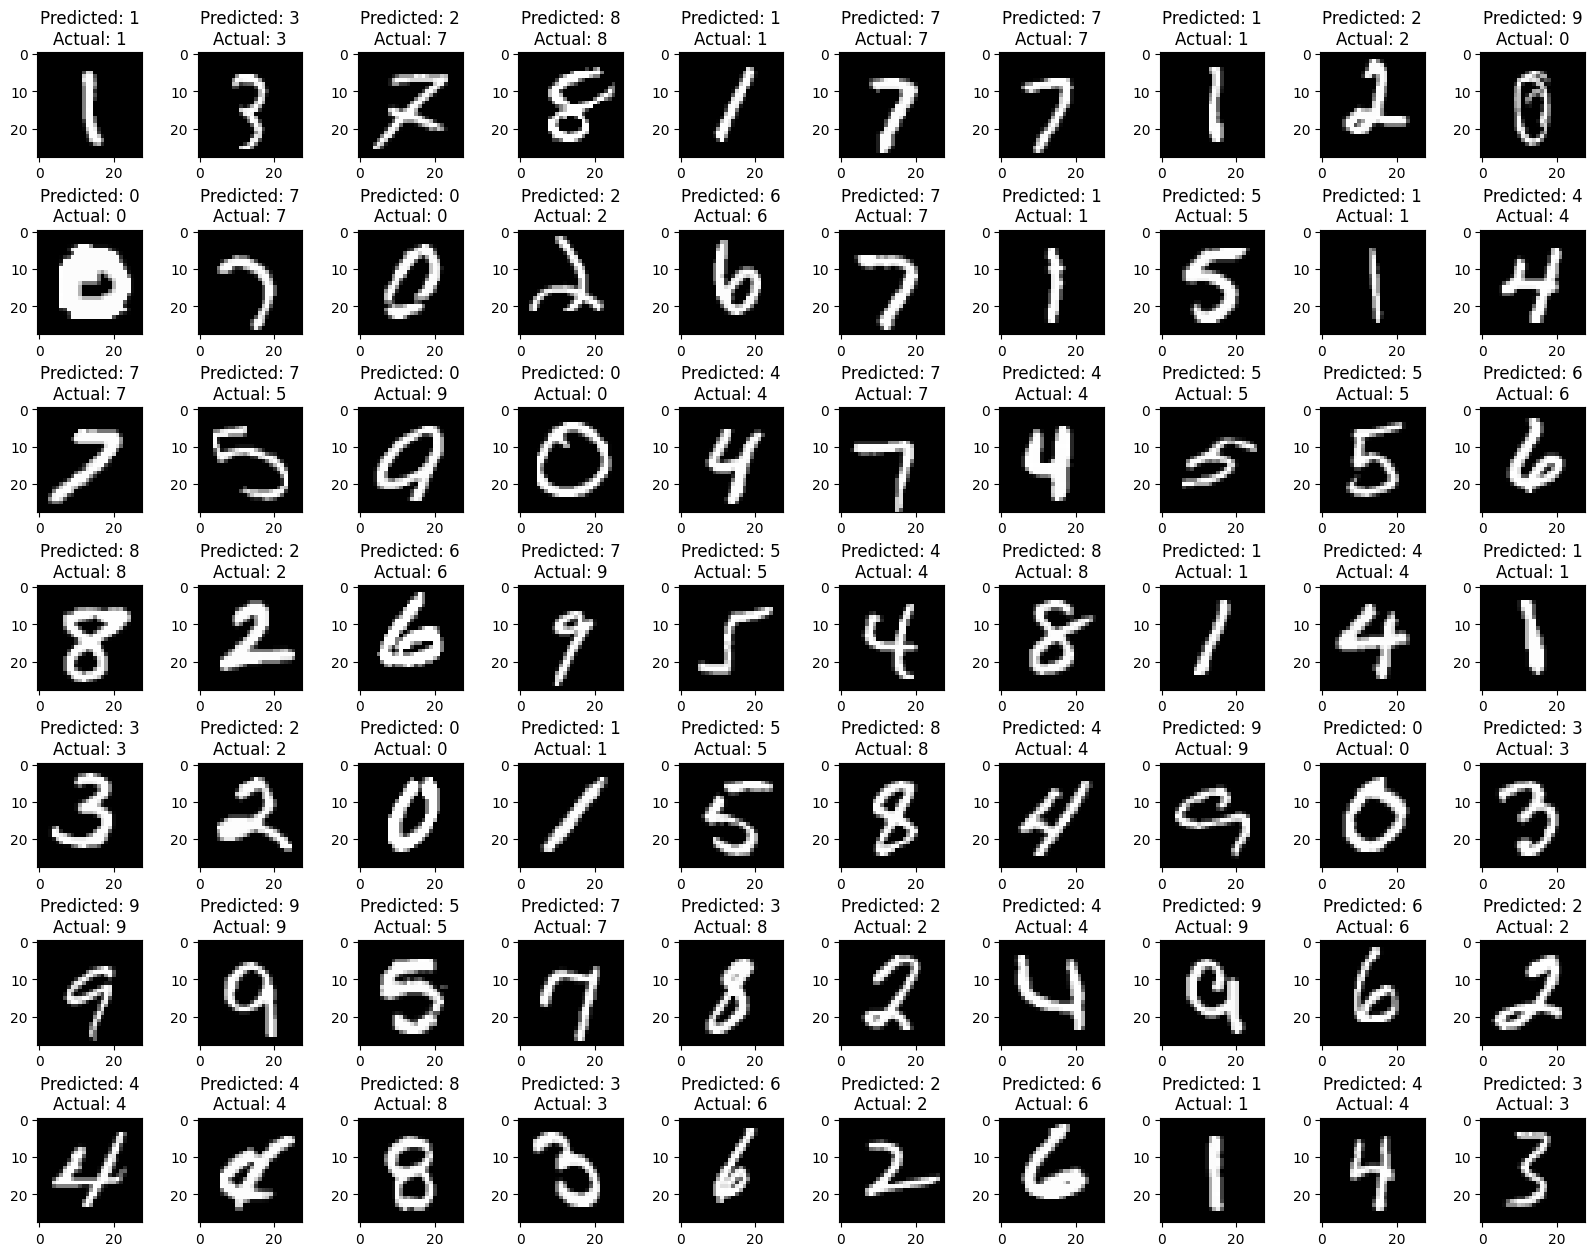

In [25]:
fig, axs = plt.subplots(7, 10, figsize=(20, 15), gridspec_kw={'hspace': 0.7, 'wspace': 0.5})

indices = random.sample(range(len(test_loader.dataset)), 70)

for i, ax in enumerate(axs.flatten()):
    image, label = test_loader.dataset[indices[i]]
    image_np = image.cpu().numpy()
    ax.imshow(image_np.squeeze(), cmap='gray', interpolation='none')
    input_image = torch.Tensor(image_np).view(1, 1, 28, 28)
    with torch.no_grad():
        y_pred = net(input_image)

    _, predicted = torch.max(y_pred, 1)
    ax.set_title(f'Predicted: {predicted.item()}\nActual: {label.item()}')

for i in range(len(indices), len(axs.flatten())):
    axs.flatten()[i].axis('off')

plt.subplots_adjust(bottom=0.1)

plt.show()

In [26]:
gradients = []
for param in net.parameters():
    gradients.append(param.grad.clone())

In [27]:
gradients

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([-3.3249e-03, -3.3921e-04,  1.9111e-03, -1.9058e-03, -1.5883e-03,
          5.6912e-03,  1.3796e-03,  0.0000e+00,  4.2377e-03, -6.2072e-04,
          8.8961e-04, -1.8223e-03,  2.7153e-05, -1.1957e-03, -2.0591e-04,
          1.8437e-03, -8.3484e-04, -3.5412e-03,  2.4618e-03, -3.2503e-03,
         -5.5098e-05, -2.1677e-04, -2.7709e-04,  3.6205e-03,  9.7791e-04,
         -2.6284e-03, -3.7695e-04,  6.6447e-04, -2.4848e-03,  4.1167e-03,
         -2.7595e-03, -3.4428e-05,  7.3017e-04, -3.1903e-03, -2.2285e-03,
          4.7102e-03, -4.4767e-03, -1.8431e-03,  2.5827e-03, -4.7304e-04,
         -2.9022e-03,  3.1714e-03, -3.6101e-03, -8.9040e-05, -6.5109e-04,
          7.5433e-05,  2.6228e-05,  8.2649e-03, -3.3835e-03, -1.6578e-04

In [28]:
print("Model's parameters:")
for param_tensor, param_value in net.state_dict().items():
    print(param_tensor, "\n", param_value)

Model's parameters:
fc1.weight 
 tensor([[ 0.0124, -0.0068,  0.0224,  ...,  0.0232,  0.0092,  0.0075],
        [ 0.0196,  0.0211, -0.0089,  ...,  0.0007, -0.0255,  0.0211],
        [-0.0145,  0.0116,  0.0345,  ...,  0.0345, -0.0165,  0.0147],
        ...,
        [-0.0341, -0.0127, -0.0195,  ..., -0.0313,  0.0140,  0.0056],
        [-0.0286, -0.0109, -0.0331,  ...,  0.0296,  0.0024, -0.0246],
        [ 0.0131, -0.0185,  0.0099,  ...,  0.0272,  0.0249, -0.0066]])
fc1.bias 
 tensor([ 0.0289,  0.0200,  0.0292, -0.0263,  0.0492,  0.0840, -0.0082,  0.0407,
         0.0883,  0.0249,  0.1223, -0.0709,  0.0582,  0.0056, -0.0607, -0.0006,
         0.0371,  0.0215,  0.0187,  0.0132,  0.0596,  0.0723, -0.0113,  0.0844,
         0.0424,  0.0277,  0.0373,  0.0550, -0.0144,  0.0813,  0.0255, -0.0142,
        -0.0283, -0.0365,  0.0232,  0.0328,  0.0089, -0.0182,  0.0879,  0.0692,
        -0.0303,  0.0071, -0.0096,  0.0895, -0.0068, -0.0013,  0.0267,  0.1274,
        -0.0581,  0.0820, -0.0243,  0.0194